
# Evidence (Guideline) Concordance — Evaluation Notebook

**Purpose:** Evaluate evidence (guideline) concordance by comparing model recommendations against a versioned, case‑specific guideline answer key using exact‑ID and semantic matching, with transparent audit trails and summary metrics.

**Date:** 10/16/2025

**Author:** Ishaan Kejriwal

## Table of Contents
1. [Overview](#1-overview)
2. [Metric Defintion](#2-metric-definition)
3. [Setup & Imports](#setup)
4. [Configuration & Inputs](#config)
5. [Data Schema & Loading](#schema)
6. [Normalization & Vocabulary](#norm)
7. [Matching Logic](#matching)
8. [Scoring & Aggregation](#scoring)
9. [Reporting & Visuals](#reporting)
10. [Audit Tables & Exports](#audit)
11. [Appendix: Helper Utilities](#appendix)


## 1. Overview <a name="overview"></a>

This notebook implements an **Evidence (Guideline) Concordance** evaluation for Clinical Decision Support (CDS) systems.  
It follows the same structured *auto-eval* pattern used in other CHAI metric notebooks:
- Load a gold evidence key of guideline-aligned recommendations for each test case.  
- Load model outputs containing the system’s predicted recommendations and any cited guideline IDs.  
- Load a concept map linking aliases or synonyms (e.g., “ACE inhibitor”) to canonical guideline IDs.  
- Perform exact-ID and semantic matching between model recommendations and guideline standards.  
- Assign a categorical label (**Exact**, **Semantic**, **For-consideration**, or **Not**) and compute scores (binary, three-bucket, or weighted).  
- Summarize results as overall concordance rates and mean scores, generate basic visualizations, and export JSON/CSV audit tables for transparent review.


## 2. Metric Definition <a name="metric-definition"></a>

**Metric:** *Evidence (Guideline) Concordance*  
**Objective:** Evaluate how well CDS or AI-generated recommendations align with established, evidence-based clinical guidelines.

**What we check:**
- Whether the model’s recommendation matches a **reference guideline ID** or **approved equivalent**.  
- **Exact-ID matches** (model cites the correct guideline or equivalent).  
- **Semantic matches** (model uses a correct recommendation phrase or synonym mapped to the guideline).  
- **For-consideration** cases (related but less precise or lower-evidence recommendations).  
- Detection of **non-concordant** outputs that contradict or omit the guideline.

**Recommended summary KPIs:**
- `% cases concordant (Exact + Semantic)`  
- `Mean weighted concordance score`  
- `Distribution of label categories (Exact / Semantic / For-consideration / Not)`  
- (Optional) `Per-guideline or per-condition concordance rates`

**Suggested pass criteria (tunable):**
- `≥ 90%` of cases show Exact or Semantic concordance  
- Mean weighted concordance score `≥ 0.85`  
- Minimal (<5%) Not-concordant outputs for critical guidelines


## 3) Setup & Imports <a id='setup'></a>

In [10]:

# Core
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple, Any
import ast
import json
import os
import math

# Data
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


## 4. Configuration & Inputs <a name="config"></a>

This section defines the file paths and core parameters used for the evaluation.  
Users can point the notebook to their own datasets by updating the CSV paths below:

- **Evidence key** → the reference “gold” guidelines for each case.  
- **Concept map** → alias-to-guideline mapping (for semantic matching).  
- **Model outputs** → system-generated recommendations with guideline references or text.  

You can also configure scoring behavior:  
- `TOP_K` controls how many top recommendations per case are evaluated.  
- `SCHEME` selects the scoring method (`binary`, `three_bucket`, or `weighted`).  
- `WEIGHTS` adjusts the contribution of each label type to the final concordance score.


In [ ]:

# Input paths (edit as needed)
DATA_DIR = "."  # If running in same folder as the CSVs; change to an absolute path if needed
EVIDENCE_KEY_CSV = os.path.join(DATA_DIR, "csvs/concept_map.csv")
CONCEPT_MAP_CSV = os.path.join(DATA_DIR, "csvs/concept_map.csv")
MODEL_OUTPUTS_CSV = os.path.join(DATA_DIR, "csvs/model_outputs.csv")

# Scoring options
TOP_K = 3  # consider top-K model recommendations per case
SCHEME = "weighted"  # one of: "binary", "three_bucket", "weighted"

# Label weights (used if SCHEME='weighted')
WEIGHTS = {"Exact": 1.0, "Semantic": 0.75, "For-consideration": 0.5, "Not": 0.0}

# For three     -bucket scoring, anything in {"Exact","Semantic"} -> Recommended,
# "For-consideration" stays as is, "Not" is not-recommended.


## 5. Data Schema & Loading <a name="schema"></a>

This section loads the three core input files and prepares them for evaluation.  
Each file has a defined schema to ensure consistent comparisons:

- **`evidence_key.csv`** → reference guideline data for each test case (ID, text, version, allowed equivalents, contraindications, evidence strength).  
- **`concept_map.csv`** → mapping of aliases or synonyms to canonical guideline IDs for semantic matching.  
- **`model_outputs.csv`** → model-predicted recommendations, each with rank, confidence, and optional guideline references.  

The notebook reads each CSV into a DataFrame, converts list-like strings (e.g., `["A","B"]`) into actual Python lists, and displays sample rows to confirm correct structure before scoring begins.


In [13]:

# Expected columns:
# evidence_key.csv:
#   case_id, guideline_id, guideline_text, version, allowed_equivalents, contraindications, strength
# concept_map.csv:
#   alias, canonical_id
# model_outputs.csv:
#   case_id, rank, pred_id, pred_text, references, confidence

def _load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    return df

evidence_key = _load_csv(EVIDENCE_KEY_CSV)
concept_map = _load_csv(CONCEPT_MAP_CSV)
model_outputs = _load_csv(MODEL_OUTPUTS_CSV)

# Parse list-like strings into Python lists (if present)
def _maybe_parse_list_like(x):
    if isinstance(x, str) and x.strip().startswith("[") and x.strip().endswith("]"):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    return x

for col in ["allowed_equivalents", "contraindications"]:
    if col in evidence_key.columns:
        evidence_key[col] = evidence_key[col].apply(_maybe_parse_list_like)

if "references" in model_outputs.columns:
    model_outputs["references"] = model_outputs["references"].apply(_maybe_parse_list_like)

display(evidence_key.head(3))
display(concept_map.head(3))
display(model_outputs.head(3))


,case_id,guideline_id,guideline_text,version,allowed_equivalents,contraindications,strength
0,C001,ADA_2024_9_4,Start metformin for T2D unless eGFR<30,ADA_2024,[],[],Strong
1,C002,NCCN_BR_2025_A1,Avoid NSAIDs in stage 4-5 CKD,NCCN_2025,[],[],Strong
2,C003,ACC_AHA_HTN_2022_ACE1,Use ACE inhibitor for hypertension,ACC_AHA_2022,[],[],Strong


,alias,canonical_id
0,metformin,ADA_2024_9_4
1,biguanide,BIGUANIDE_CLASS
2,ace inhibitor,ACC_AHA_HTN_2022_ACE1


,case_id,rank,pred_id,pred_text,references,confidence
0,C001,1,Pred_Met_01,Start metformin,[],0.82
1,C001,2,Pred_SGLT2_01,Consider SGLT2 inhibitor,[],0.41
2,C002,1,Pred_NSAID_01,Avoid NSAIDs,[],0.70


## 6. Normalization & Vocabulary <a name="norm"></a>

This step standardizes text and builds a lightweight **vocabulary map** for semantic matching.  
Aliases (e.g., “ACE inhibitor”, “metformin”) are linked to their **canonical guideline IDs** using the `concept_map.csv` file.  
All text is lowercased and stripped of whitespace for consistent comparison.  
The helper function `map_to_canonical_id()` performs a simple substring match to connect model recommendation text to its corresponding guideline ID — semantic alignment layer before scoring


In [4]:

# Build a quick alias -> canonical_id map
ALIAS2CANON = dict(zip(concept_map["alias"].str.lower().str.strip(),
                       concept_map["canonical_id"].str.strip()))

def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    return text.lower().strip()

def map_to_canonical_id(text: str) -> Optional[str]:
    t = normalize_text(text)
    # naive contains match; for production, prefer a tokenizer + ontology
    for alias, can_id in ALIAS2CANON.items():
        if alias in t:
            return can_id
    return None


## 7. Matching Logic <a name="matching"></a>

This section determines **how a model recommendation is judged** against the guideline key.  
We evaluate each case’s top-K predictions in a fixed priority order:

1) Exact: the model **cites a guideline ID** that appears in the allowed set (primary ID or approved equivalents).  
2) Semantic: the model’s **text maps** (via the alias→canonical vocabulary) to a guideline in the allowed set.  
3) For-consideration: the text maps to a **related** canonical ID (e.g., class-level or nearby alias) but not listed as primary/allowed.  
4) Not: no acceptable match (or disqualifiers would apply if patient gates are enabled).

The best label found among the top-K is used to compute a **case score** according to the selected scheme  
(`binary`, `three_bucket`, or `weighted`). The result is a per-case record with the chosen label, score, and match metadata.


In [14]:

MATCH_ORDER = ["Exact", "Semantic", "For-consideration", "Not"]

def _allowed_ids(row: pd.Series) -> set:
    ids = set([row["guideline_id"]])
    eqv = row.get("allowed_equivalents", []) or []
    for e in eqv:
        if isinstance(e, str):
            ids.add(e)
    return ids

def evaluate_one(case_row: pd.Series, pred_row: pd.Series) -> Tuple[str, Dict[str, Any]]:
    # 0) Disqualifiers demo (stub): in a real setup, you'd check patient-level features
    # For this template, we don't have patient attributes; keep placeholder logic.
    # If you add patient features (e.g., eGFR), evaluate here and return ("Not", {"reason": "..."})
    
    # 1) Exact-ID match: any overlap in references and allowed IDs
    ids_allowed = _allowed_ids(case_row)
    refs = set(pred_row.get("references", []) or [])
    if ids_allowed & refs:
        return "Exact", {"matched_ids": list(ids_allowed & refs)}
    
    # 2) Semantic concept match via alias->canonical mapping
    can_from_text = map_to_canonical_id(pred_row.get("pred_text", ""))
    if can_from_text and can_from_text in ids_allowed:
        return "Semantic", {"canonical_id": can_from_text}
    
    # 3) For-consideration (optional heuristic): same class or nearby alias not listed as primary
    if can_from_text:
        return "For-consideration", {"canonical_id": can_from_text}
    
    return "Not", {}

def score_case(case_id: str, top_k: int = 3) -> Dict[str, Any]:
    # Retrieve the reference (gold) row for the given case
    case = evidence_key.loc[evidence_key["case_id"] == case_id]
    if case.empty:
        return {"case_id": case_id, "label": "Not", "score": 0.0, "meta": {"error": "missing case"}}
    case_row = case.iloc[0]

    # Retrieve all model predictions for this case
    preds = model_outputs[model_outputs["case_id"] == case_id].copy()
    if preds.empty:
        return {"case_id": case_id, "label": "Not", "score": 0.0, "meta": {"error": "no predictions"}}

    # Sort predictions by rank (ascending) and confidence (descending)
    preds.sort_values(["rank", "confidence"], ascending=[True, False], inplace=True)
    preds = preds.head(top_k)  # keep only top-k predictions for scoring

    # Initialize best match tracking
    best_label, best_meta = "Not", {}
    for _, r in preds.iterrows():
        label, meta = evaluate_one(case_row, r)
        # Keep the highest-priority match according to MATCH_ORDER
        if MATCH_ORDER.index(label) < MATCH_ORDER.index(best_label):
            best_label, best_meta = label, meta

    # Compute numeric score based on the evaluation scheme
    if SCHEME == "binary":
        score = 1.0 if best_label in {"Exact", "Semantic"} else 0.0
    elif SCHEME == "three_bucket":
        # No numeric needed; but return a convenience score
        score = 1.0 if best_label in {"Exact", "Semantic"} else (0.5 if best_label == "For-consideration" else 0.0)
    else:  # weighted
        score = WEIGHTS.get(best_label, 0.0)

    # Return structured evaluation result for the given case

    return {"case_id": case_id, "label": best_label, "score": score, "meta": best_meta}

# Run scoring over all cases in the evidence key
results = pd.DataFrame([score_case(cid, top_k=TOP_K) for cid in evidence_key["case_id"].tolist()])
results


,case_id,label,score,meta
0,C001,Semantic,0.75,{'canonical_id': 'ADA_2024_9_4'}
1,C002,Semantic,0.75,{'canonical_id': 'NCCN_BR_2025_A1'}
2,C003,Semantic,0.75,{'canonical_id': 'ACC_AHA_HTN_2022_ACE1'}


## 8. Scoring & Aggregation <a name="scoring"></a>

Here we convert per-case labels into headline metrics.  
- **Binary concordance** counts *Exact* and *Semantic* as concordant and reports the overall percentage.  
- **Weighted score** averages label weights (configurable via `WEIGHTS`) to provide a single summary index.  
- We also include a **label distribution** to show how often each category occurs.  

The `summarize()` function aggregates these values across all cases, returning a compact table with:
- total `n_cases`,  
- `% cases concordant (Exact + Semantic)`,  
- `mean_weighted_score`, and  
- a JSON-style `label_breakdown` for quick QA and reporting.


In [15]:

def summarize(results_df: pd.DataFrame) -> pd.DataFrame:
    n = len(results_df)
    pct_concordant_binary = (results_df["label"].isin(["Exact", "Semantic"]).mean() * 100.0) if n > 0 else 0.0
    mean_weighted = results_df["score"].mean() if n > 0 else 0.0
    breakdown = results_df["label"].value_counts(normalize=True).to_dict() if n > 0 else {}
    return pd.DataFrame({
        "n_cases":[n],
        "pct_concordant_binary":[pct_concordant_binary],
        "mean_weighted_score":[mean_weighted],
        "label_breakdown":[breakdown]
    })

summary = summarize(results)
summary


,n_cases,pct_concordant_binary,mean_weighted_score,label_breakdown
0,3,100.0,0.75,{'Semantic': 1.0}


## 9. Reporting & Visuals <a name="reporting"></a>

This section provides quick visuals for QA and stakeholder review:
- A **bar chart** of the label distribution (Exact / Semantic / For-consideration / Not) to spot mismatch patterns.
- A **per-case score plot** to see spread, outliers, and any clustering by case index.

Use these to verify that most cases fall into concordant categories, and to flag cases with low scores for audit.  
(For deeper analysis, consider stratifying by guideline version, condition, or site and adding confidence intervals.)


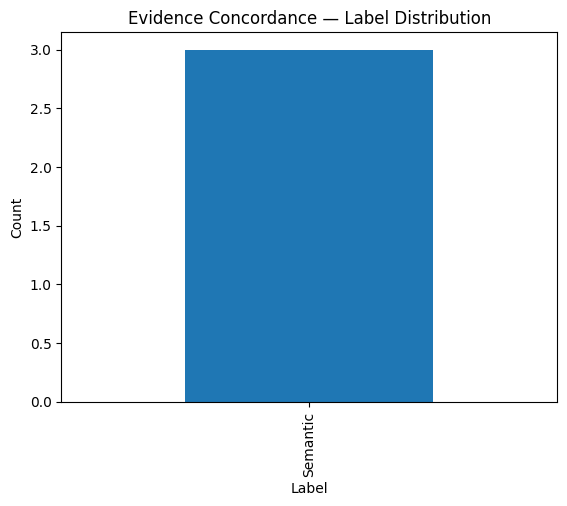

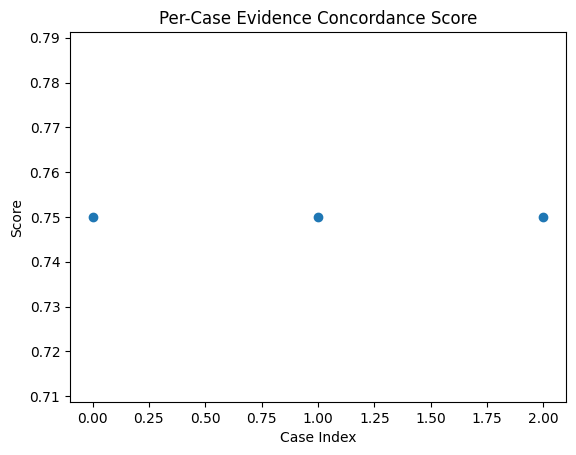

In [16]:

# Bar chart: label distribution
label_counts = results["label"].value_counts().sort_index()
plt.figure()
label_counts.plot(kind="bar")
plt.title("Evidence Concordance — Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Scatter: score by case
plt.figure()
plt.scatter(range(len(results)), results["score"])
plt.title("Per-Case Evidence Concordance Score")
plt.xlabel("Case Index")
plt.ylabel("Score")
plt.show()


## 10. Audit Tables & Exports <a name="audit"></a>

This section produces a transparent audit view and saves machine-readable outputs:
- **Audit table:** joins each case’s guideline ID/text/version with the model’s top recommendation and any cited guideline references, plus the final label and score. Use this to spot false positives/negatives and verify mapping logic.
- **Exports:** writes a compact JSON summary and two CSVs (**results** and **audit**) into `outputs/` for downstream dashboards or CI checks.

Files written:
- `outputs/evidence_concordance_summary.json` — headline KPIs (n_cases, % concordant, mean score).
- `outputs/evidence_concordance_results.csv` — per-case labels and scores.
- `outputs/evidence_concordance_audit.csv` — side-by-side guideline vs. model details for human review.


In [17]:

# Join back key columns for a readable audit
audit = results.merge(evidence_key[["case_id","guideline_id","guideline_text","version","strength"]],
                      on="case_id", how="left")

# Show side-by-side: top prediction text/refs for transparency
def pick_top_pred_text(cid: str) -> Dict[str, Any]:
    preds = model_outputs[model_outputs["case_id"] == cid].copy()
    if preds.empty:
        return {"top_pred_text": None, "top_refs": []}
    preds.sort_values(["rank", "confidence"], ascending=[True, False], inplace=True)
    r = preds.iloc[0]
    return {"top_pred_text": r.get("pred_text"), "top_refs": r.get("references", [])}

tops = [pick_top_pred_text(cid) for cid in audit["case_id"]]
audit["top_pred_text"] = [t["top_pred_text"] for t in tops]
audit["top_refs"] = [t["top_refs"] for t in tops]

display(audit)

# Export JSON + CSV
export_dir = "outputs"
os.makedirs(export_dir, exist_ok=True)

summary_path = os.path.join(export_dir, "evidence_concordance_summary.json")
results_path = os.path.join(export_dir, "evidence_concordance_results.csv")
audit_path   = os.path.join(export_dir, "evidence_concordance_audit.csv")

with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(json.loads(summary.to_json(orient="records")), f, indent=2)

results.to_csv(results_path, index=False, encoding="utf-8")
audit.to_csv(audit_path, index=False, encoding="utf-8")

print("Wrote:")
print(" -", summary_path)
print(" -", results_path)
print(" -", audit_path)


,case_id,label,score,meta,guideline_id,guideline_text,version,strength,top_pred_text,top_refs
0,C001,Semantic,0.75,{'canonical_id': 'ADA_2024_9_4'},ADA_2024_9_4,Start metformin for T2D unless eGFR<30,ADA_2024,Strong,Start metformin,[]
1,C002,Semantic,0.75,{'canonical_id': 'NCCN_BR_2025_A1'},NCCN_BR_2025_A1,Avoid NSAIDs in stage 4-5 CKD,NCCN_2025,Strong,Avoid NSAIDs,[]
2,C003,Semantic,0.75,{'canonical_id': 'ACC_AHA_HTN_2022_ACE1'},ACC_AHA_HTN_2022_ACE1,Use ACE inhibitor for hypertension,ACC_AHA_2022,Strong,Start ACE inhibitor,[]


Wrote:
 - outputs\evidence_concordance_summary.json
 - outputs\evidence_concordance_results.csv
 - outputs\evidence_concordance_audit.csv


## 11. Appendix: Helper Utilities <a name="appendix"></a>

This section serves as a lightweight sandbox for optional or future add-ons.  
Users can place reusable helper functions here—for example:
- **Patient-feature gates** (e.g., skip metformin if eGFR < 30).  
- **Version-drift policies** (treat 2023 vs 2025 guideline IDs as “For-consideration”).  
- **Inter-rater checks** (e.g., Cohen’s κ for manual labels).  
- **Conversion helpers** (e.g., map three-bucket labels → binary).

Keeping this section isolated ensures the core evaluation pipeline stays clean, while still leaving space for modular extensions later.


In [18]:

# Placeholder for future helpers, e.g., patient-feature gating, version drift policies,
# or inter-rater agreement scaffolding.
#
# Example: simple policy to map three-bucket labels to a binary for headline reporting
def to_binary(label: str) -> int:
    return 1 if label in {"Exact","Semantic"} else 0
